In [1]:
import numpy as np
import scipy.io
import WENDy as wd
import utils
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time
from scipy.interpolate import interp1d


In [2]:
odes = ['wendydata_Logistic_Growth.mat',
        'wendydata_Lotka_Volterra.mat',
        'wendydata_FitzHugh-Nagumo.mat',
        'wendydata_Hindmarsh-Rose.mat',
        'wendydata_biochemM1.mat']

ode_num = 4 # select ODE from list above
data = scipy.io.loadmat(odes[ode_num])
t = data['t'].reshape(-1)
x = data['x']
#features = data['features']
params = data['params'][0]
x0 = data['x0'][0]
true_vec = data['true_vec']
rhs_p = data['rhs_p']

if ode_num == 0: 
    features = [
        [lambda x: x, lambda x: x**2]
    ]
elif ode_num == 1:
    features = [
        [lambda x, y: x, lambda x, y: x*y],
        [lambda x, y: y, lambda x, y: x*y]
    ]
elif ode_num == 2: 
    features = [
        [lambda x, y: x, lambda x, y: x**3, lambda x, y: y],
        [lambda x, y: x, lambda x, y: x*0 + 1, lambda x, y: y]
    ]
elif ode_num == 3:
    features = [
        [lambda x, y, z: y, lambda x, y, z: x**3, lambda x, y, z: x**2, lambda x, y, z: z],
        [lambda x, y, z: x*0+1, lambda x, y, z: x**2, lambda x, y, z: y],
        [lambda x, y, z: x, lambda x, y, z: x*0+1, lambda x, y, z: z],
    ]
else: 
    features = [
        [lambda S, dS, R, RS, Rpp: S, lambda S, dS, R, RS, Rpp: S*R, lambda S, dS, R, RS, Rpp:RS],
        [lambda S, dS, R, RS, Rpp:S],
        [lambda S, dS, R, RS, Rpp:S*R, lambda S, dS, R, RS, Rpp:RS, lambda S, dS, R, RS, Rpp: Rpp/(0.3+Rpp)],
        [lambda S, dS, R, RS, Rpp: S*R, lambda S, dS, R, RS, Rpp: RS],
        [lambda S, dS, R, RS, Rpp: RS, lambda S, dS, R, RS, Rpp: Rpp/(0.3+Rpp)],
    ]
rhs_p = lambda t, x: utils.rhs_fun(features, params, x)

In [3]:
def rhs_fun(features, params, x):
    nstates = len(x)
    x = tuple(x)
    dx = np.zeros(nstates)
    for i in range(nstates):
        dx[i] = np.sum([f(*x)*p for f, p in zip(features[i], params[i])])
    return dx

def customODE():
    features = [
        [lambda x, y, z: x*y],
        [lambda x, y, z: x*y, lambda x, y, z: y],
        [lambda x, y, z: y]
    ]
    params = [np.array([-0.003]), np.array([0.003, -0.25]), np.array([0.25])]

    x0 = np.array([499, 1, 0])
    t = np.arange(0, 40.04, 0.04)
    tspan = (t[0], t[-1])
    tol_ode = 1e-8

    rhs_p = lambda t, x: rhs_fun(features, params, x)
    true_vec = np.concatenate(params).reshape(-1, 1)
    options_ode_sim = {"rtol": tol_ode, "atol": tol_ode*np.ones(len(x0))}

    t0 = time.time()
    sol = solve_ivp(rhs_p, t_span = tspan, y0=x0, t_eval=t, rtol=tol_ode, atol=tol_ode)
    #print("sim time =", time.time() - t0)
    x = sol.y.T
    t = sol.t
    #plt.plot(t, x)
    return x, t, params, x0, true_vec, features, rhs_p

x, t, params, x0, true_vec, features, rhs_p = customODE()

In [4]:
def gen_noise(U_exact, sigma_NR, noise_dist, noise_alg):
    if noise_alg == 0:  # additive
        stdv = np.square(np.sqrt(np.mean(np.square(U_exact))))
    elif noise_alg == 1:  # multiplicative
        stdv = 1
    dims = U_exact.shape
    if noise_dist == 0:  # white noise
        if sigma_NR > 0:
            sigma = sigma_NR * np.sqrt(stdv)
        else:
            sigma = -sigma_NR
        noise = np.random.normal(0, sigma, dims)
    elif noise_dist == 1:  # uniform noise
        if sigma_NR > 0:
            sigma = np.sqrt(3 * np.square(sigma_NR) * stdv)
        else:
            sigma = -sigma_NR
        noise = sigma * (2 * np.random.rand(*dims) - 1)
    if noise_alg == 0:  # additive
        U = U_exact + noise
    elif noise_alg == 1:  # multiplicative
        U = U_exact * (1 + noise)
    noise_ratio_obs = np.linalg.norm(U - U_exact) / np.linalg.norm(U_exact)
    return U, noise, noise_ratio_obs, sigma

In [5]:
#x, t, params, x0, true_vec, features, rhs_p =  utils.customODE()

subsamp =  1 # subsample data in time
tobs = t[::subsamp]
xsub = x[::subsamp, :]
M, nstates = xsub.shape

#add noise
np.random.seed(1)
noise_ratio = 0
noise_dist = 0
noise_alg = 0
rng_seed = np.random.get_state()[1][0]
np.random.seed(rng_seed)
xobs, noise, _, sigma = gen_noise(xsub, noise_ratio, noise_dist, noise_alg)

In [6]:
model = wd.WENDy(toggle_VVp_svd = np.nan)
w_hat = model.fit(xobs, tobs, features)
y = model.simulate(x[0], t)

/Users/chtr8711/Documents/GitHub/PyWendy/WENDy.py:578: RuntimeWarning: invalid value encountered in scalar divide
  m = (U[-1] - U[0]) / (x[-1] - x[0])


In [7]:
#relative error of the parameters:
error = np.linalg.norm(w_hat - true_vec)/np.linalg.norm(true_vec)
error

1.0469917988754271e-09

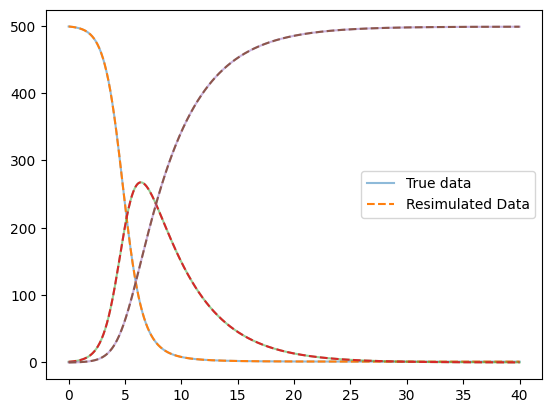

In [8]:
labels = {'orig': 'True data', 'new': 'Resimulated Data'}
for dim in range(x.shape[1]):
    plt.plot(tobs, xobs[:, dim], alpha = .5,  label = labels['orig'])
    plt.plot(tobs, y[:, dim], '--',  label = labels['new'])
    labels['orig'] = '_nolegend_'
    labels['new'] = '_nolegend_'
plt.legend()
    

